In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(0)

In [3]:
pd.options.mode.copy_on_write = True

# Vectorization and Loops

In pandas, vectorization refers to performing operations on entire arrays of data at once, rather than iterating over values one by one using a Python for loop. This way, you can run operations across a whole Series, Index, or DataFrame in a single shot, which can significantly enhance the performance depending on the operations you're running. Examples of vectorized operations include arithmetic and boolean operations, as well as string manipulations using `.str` methods on text columns.

## NumPy Vectorization

NumPy, short for Numerical Python, is a foundational package for numerical computing in Python. It provides efficient multidimensional array capabilities, fast array-oriented arithmetic operations, and flexible broadcasting. NumPy's performance benefits come from its implementation in C and its use of homogeneous arrays which allows for an optimized memory layout.

NumPy's optimized memory layout enhances memory handling and maximizes data locality, reducing the frequency of cache misses and thereby speeding up operations due to better cache utilization.

Pandas leverages NumPy as its default backend engine. This means pandas can use NumPy’s vectorization capabilities to perform operations on Series, Index, and DataFrames much faster than vanilla Python.

Note, however, that the term vectorization also refers to running operations on arrays using SIMD (Single Instruction, Multiple Data) parallelism, which is a key technique for speeding up numerical operations on data arrays. Starting with NumPy 1.23, SIMD capabilities were introduced to take full advantage of CPU capabilities and cache, significantly speeding up numeric operations.

## Pandas Vectorization

As mentioned, in pandas, vectorization refers to performing operations across an entire Series, Index, or DataFrame at once. On the other hand, in NumPy, it means running element-wise operations using optimized C loops instead of Python loops. From version 1.23, these C loops may utilize SIMD capabilities.

Using pandas vectorization, you can leverage NumPy's ability to execute operations in machine code, depending on the operation. For instance, element-wise arithmetic and boolean operations over numeric data in pandas will use SIMD instructions supported by NumPy. Otherwise, pandas will run a specialized Python loop with numerous optimizations, particularly related to memory arrangement, resulting in better performance than a traditional Python for loop.


# Benchmark

To clarify the performance differences between various vectorized and non-vectorized operations in pandas, this section presents a very naive and straightforward benchmark. In this benchmark, we examine the performance differences when using Python loops (iterrows), apply, map, specialized numpy operations, string operations, and other considerations.

## Vectorized Operations x Python Loops

This section contains a benchmark that explores the performance differences in arithmetic operations between vectorized (overloaded operators) and non-vectorized (loop & apply) methods.

In [4]:
n_rows = 1_000_000
n_cols = 2

values = np.random.randint(low=10, high=100, size=(n_rows, n_cols))
columns = [f'col_{i}' for i in range(0, n_cols)]
df = pd.DataFrame(values, columns=columns)

df.head()

,col_0,col_1
0,54,57
1,74,77
2,77,19
3,93,31
4,46,97


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   col_0   1000000 non-null  int64
 1   col_1   1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
%%timeit

ratios = []
for _, row in df.iterrows():
    ratio = 100 * (row['col_0'] / row['col_1'])
    ratios.append(ratio)

df['ratio'] = ratios

# Using list comprehension if far better
# ratios = [100 * (row['col_0'] / row['col_1']) for _, row in df.iterrows()]
# df['ratio'] = ratios

14.7 s ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
def ratio(row):
    return 100 * (row['col_0'] / row['col_1'])

In [8]:
%%timeit
df['ratio'] = df.apply(ratio, axis=1)

3.96 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
df['ratio'] = 100 * (df['col_0'] / df['col_1'])

2.71 ms ± 20.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit

X_array = df['col_0'].to_numpy()
Y_array = df['col_1'].to_numpy()

ratios = 100 * (X_array / Y_array)

df['ratio'] = ratios

2.43 ms ± 22.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Conditional operations

Conditional operations are very common during data manipulations in pandas, and it's a situation where people often use apply, especially when it involves using information from multiple columns in that row.

However, it's possible to use vectorized operations for these scenarios with minimal effort.

This benchmark demonstrates how to do this and highlights the differences in execution speed performance.

In [11]:
def generate_library_dataframe(n_rows):
    titles = [f'Book {i}' for i in range(n_rows)]
    genres = np.random.choice(['Fiction', 'Horror', 'Science'], n_rows)
    year_published = np.random.randint(1980, 2023, n_rows)
    num_pages = np.random.randint(50, 1000, n_rows)
    
    data = {
        'title': titles,
        'genre': genres,
        'year_published': year_published,
        'num_pages': num_pages
    }
    return pd.DataFrame(data)

In [12]:
df = generate_library_dataframe(1_000_000)
df.head()

,title,genre,year_published,num_pages
0,Book 0,Science,2003,366
1,Book 1,Fiction,1993,638
2,Book 2,Fiction,2013,809
3,Book 3,Fiction,2014,240
4,Book 4,Fiction,1994,984


In [13]:
def should_read_on_row(row):
    if row['genre'] == 'Science':
        return True
    else:
        return False

In [14]:
def should_read_on_field(genre):
    if genre == 'Science':
        return True
    else:
        return False

In [15]:
%%timeit
df['should_read'] = df.apply(should_read_on_row, axis=1)

2.87 s ± 387 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
df['should_read'] = df['genre'].apply(should_read_on_field)

104 ms ± 483 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
df['should_read'] = df['genre'].map(should_read_on_field)

104 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
df['should_read'] = np.where(df['genre'] == 'Science', True, False)

41.6 ms ± 881 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit
df['should_read'] = np.vectorize(should_read_on_field)(df['genre'])

80.9 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Tip: Conditions with Dictionary Lookup

In some scenarios, a large number of if-then-else statements are needed to apply the desired logic. A better approach, however, is to use dictionaries when the condition being tested is based solely on a single value.

Below are some examples:

In [20]:
avg_rate = {
    'Fiction': 5,
    'Horror': 3,
    'Science': 4,
}

def get_avg_rate(genre):
    return avg_rate.get(genre, 0)

In [21]:
%%timeit

df['genre'].map(avg_rate).fillna(0)

33.6 ms ± 44 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit

np.vectorize(get_avg_rate)(df['genre'])

93 ms ± 702 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Multiple and nested conditions

Generally, scenarios that require the use of conditional operators are more complex than just a simple if-then-else. They may actually require multiple, nested conditions. In this case, we still have options for vectorized execution.

In [23]:
def categorize_book(row):
    if row['genre'] == 'Fiction' and row['year_published'] > 2000:
        return 'Modern Fiction'
    elif row['genre'] == 'Horror' and row['year_published'] <= 2000:
        return 'Old Horror'
    elif row['genre'] == 'Science' and row['year_published'] > 2010:
        return 'Recent Science'
    elif row['genre'] == 'Biography' and row['num_pages'] > 400:
        return 'Long Biography'
    elif row['year_published'] < 1990 and row['num_pages'] < 100:
        return 'Vintage Short Book'
    else:
        return 'Other'

In [24]:
%%timeit
df['book_category'] = df.apply(categorize_book, axis=1)

6.99 s ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
conditions = [
    (df['genre'] == 'Fiction') & (df['year_published'] > 2000),
    (df['genre'] == 'Horror') & (df['year_published'] <= 2000),
    (df['genre'] == 'Science') & (df['year_published'] > 2010),
    (df['genre'] == 'Biography') & (df['num_pages'] > 400),
    (df['year_published'] < 1990) & (df['num_pages'] < 100)
]
choices = [
    'Modern Fiction',
    'Old Horror',
    'Recent Science',
    'Long Biography',
    'Vintage Short Book'
]

In [26]:
%%timeit
df['book_category'] = np.select(conditions, choices, default='Other')

82.4 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Careful with Vectorized Strings

The Python string built-in methods simplify most text operations considerably, while complex pattern matching operations are handled using regular expressions. To enable you to apply string methods and regular expressions concisely to entire arrays of data, while also managing missing data, pandas provides a `.str` accessor on Series that lets you run various vectorized operations on strings.

However, it's important to note that "vectorized" in this context doesn't necessarily mean the code will run faster or use SIMD capabilities; it simply means that your operation will run on a whole Series at once.

In [27]:
df.head()

,title,genre,year_published,num_pages,should_read,book_category
0,Book 0,Science,2003,366,True,Other
1,Book 1,Fiction,1993,638,False,Other
2,Book 2,Fiction,2013,809,False,Modern Fiction
3,Book 3,Fiction,2014,240,False,Modern Fiction
4,Book 4,Fiction,1994,984,False,Other


In [28]:
def format_category(category):
    return category.replace(' ', '_').lower()

In [29]:
%%timeit
df['fmt_book_category'] = df['book_category'].str.replace(" ", "_").str.lower()

196 ms ± 7.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
df['fmt_book_category'] = df['book_category'].map(format_category)

142 ms ± 4.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%%timeit
df['fmt_book_category'] = np.vectorize(format_category)(df['book_category'])

283 ms ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Use the right data type

Choosing the right data type in pandas can significantly speed up operations and reduce memory usage. For example, using `int64` for columns that only require `int8` can lead to unnecessary memory consumption and larger processing time.

In [32]:
df_int64 = pd.DataFrame(np.random.randint(low=0, high=100, size=(100_000_000, 1)), columns=['0'])
df_int64.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000000 entries, 0 to 99999999
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   0       int64
dtypes: int64(1)
memory usage: 762.9 MB


In [33]:
df_int8 = pd.DataFrame(np.random.randint(low=0, high=100, size=(100_000_000, 1),dtype=np.int8), columns=['0'])
df_int8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000000 entries, 0 to 99999999
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   0       int8 
dtypes: int8(1)
memory usage: 95.4 MB


In [34]:
%%timeit
df_int64['sum_up'] = df_int64['0'] + 1

147 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
df_int8['sum_up'] = df_int8['0'] + 1

9.95 ms ± 250 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Speeding up your code even more!

Despite the various alternatives for running fast transformations in pandas, there are two key factors that significantly affect the performance of our code:

- **Python is slow:** Python is a dynamic typed languague that runs, by default, using CPython interpreter which implements Python objects from a very generic perspective through `PyObject` C structs. Consequently, there's a lot of overhead to properly just run a simple arithmetic operation between two floating-point numbers.
- **No multi-core:** Pandas doesn't use the full potential of the CPU (multi-threading/multi-core). Modern CPUs have multiple cores, and for data-level parallelism where there is no data dependency, it is crucial to split the work and process many rows in parallel. Pandas, however, does not fully leverage this capability, which can limit its performance.


### Pandaralell

Pandarallel is a package designed to parallelize pandas applying functions, enabling the usage of multiple CPU cores to improve performance in exchange for a considerable increase in memory usage.

In [36]:
!pip install pandarallel

  Using cached pandarallel-1.6.5.tar.gz (14 kB)
  Preparing metadata (setup.py) ... done
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  DEPRECATION: pandarallel is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for pandarallel ... done

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [37]:
df = generate_library_dataframe(1_000_000)
df.head()

,title,genre,year_published,num_pages
0,Book 0,Science,1985,639
1,Book 1,Horror,2017,720
2,Book 2,Fiction,2000,435
3,Book 3,Horror,1981,822
4,Book 4,Horror,2005,869


In [38]:
def apply_hash(row):
    composition = f"{row['title'].lower()}_{row['genre'].lower()}"
    return hash(composition)

In [39]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [40]:
%%timeit

df.apply(apply_hash, axis=1)

4.13 s ± 94.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit

df.parallel_apply(apply_hash, axis=1)

1.32 s ± 37.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba

Numba is a just-in-time (JIT) compiler for Python that transforms a subset of Python and NumPy code into efficient machine code at runtime, significantly improving performance for numerical computations.

Numba uses the LLVM compiler infrastructure to generate optimized machine code at import time, runtime, or statically with the pycc tool. It supports both CPU and GPU execution and integrates well with the Python scientific stack. By decorating a Python function with @jit, you can achieve native machine performance comparable to C, C++, and Fortran.

In pandas, you can use Numba in two ways:

- Specify the `engine="numba"` keyword in pandas methods that supports it.
- Create a Python function decorated with `@jit`, pass the underlying NumPy array of a Series or DataFrame (e.g. using `Series.to_numpy()`), and perform operations in a loop or vectorized manner.

In [42]:
!pip install numba

  Using cached numba-0.60.0-cp310-cp310-macosx_11_0_arm64.whl (2.7 MB)
  Using cached llvmlite-0.43.0-cp310-cp310-macosx_11_0_arm64.whl (28.8 MB)

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [43]:
import numba

In [44]:
df = pd.DataFrame(np.random.uniform(-1, 1, size=(1_000_000, 2)), columns=['a', 'b'])
df

,a,b
0,-0.543978,0.558654
1,-0.493950,0.384705
2,-0.986260,0.768287
3,-0.380660,-0.437055
4,0.604655,-0.256137
...,...,...
999995,-0.974327,0.444928
999996,-0.298591,-0.341347
999997,0.597318,0.851512
999998,0.039184,-0.829645


In [45]:
%%timeit

c_results = []
for _, row in df.iterrows():
    c_results.append(np.sqrt(row['a']**2 + row['b']**2))

16.1 s ± 239 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
def pythagoras_apply(row):
    return np.sqrt(row['a']**2 + row['b']**2)

In [47]:
%%timeit

df.apply(pythagoras_apply, axis='columns')

4.36 s ± 77.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit

np.sqrt(df['a']**2 + df['b']**2)

4.43 ms ± 211 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
@numba.jit
def pythagoras_vectorized(a, b):
    return np.sqrt(a**2 + b**2)

In [50]:
%%timeit

pythagoras_vectorized(df['a'].to_numpy(), df['b'].to_numpy())

1.16 ms ± 64.1 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
@numba.jit
def pythagoras_iterate(a, b):
    n = len(a)
    c = np.empty(n, dtype="float64")
    for i in range(n):
        c[i] = np.sqrt(a[i]**2 + b[i]**2)
    return c

In [52]:
%%timeit

pythagoras_iterate(df['a'].to_numpy(), df['b'].to_numpy())

1.19 ms ± 20.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Numba has three major options that control important behaviors such as compilation flexibility, parallelism, and GIL effects. They are nopython, parallel, and nogil.

- `nopython`: Numba will compile the function only if it can generate native machine code for the entire function. If it encounters code that it cannot compile, it will raise an error instead of falling back to object mode. The default is `False`.
- `parallel`: When True, it enables parallel execution of loops using prange. The default is `False`.
- `nogil`: When True, it releases the Global Interpreter Lock (GIL), allowing concurrent execution of multiple threads in the same process. The default is `False`.

These parameters are important because not everything can be compiled or parallelized. Understanding Numba's support limitations and behaviors is crucial to maximize efficiency.

In [53]:
@numba.jit(nopython=True, parallel=True, nogil=True)
def power2(a):
    n = len(a)
    c = np.empty(n, dtype="float64")
    for i in numba.prange(n):
        c[i] = a[i] ** 2
    return c

In [54]:
%%timeit

df['a'] ** 2

918 μs ± 19.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [55]:
%%timeit

power2(df['a'].to_numpy())

713 μs ± 23.2 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cython

Cython is a programming language that makes writing C extensions for Python as easy as Python itself. It allows you to convert Python code into C or C++ code, enabling significant performance improvements, especially for computationally intensive tasks.

For more information, check the following references:

- [Cython (writing C extensions for pandas) on Pandas Docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html#cython-writing-c-extensions-for-pandas)
- [Cython on Cython Docs](https://cython.org/)

## Numerical Expression Evaluators

You can speed up certain binary numerical and boolean operations using the `numexpr` and `bottleneck` packages.

- `numexpr` evaluates NumPy array expressions and accelerates them with better memory handling, multi-threading capabilities, and Intel's VML (Vector Math Library) for faster speeds and lower memory usage.
- `bottleneck` implements optimized algorithms in C for numerical computations, addressing common performance bottlenecks. It uses techniques like parallelism, loop unrolling, SIMD, and even OpenMP to enhance performance.

Pandas highly encourage the usage of both libraries which are used by default when installed. To install them, use:

```
pip install "pandas[performance]"
```

For more recommended dependencies, check the section [Recommended Dependencies on Pandas Docs](https://pandas.pydata.org/docs/getting_started/install.html#install-recommended-dependencies).

# Conclusion

When working with pandas, you often need to perform element-wise transformations. These transformations can vary widely, from simple arithmetic operations to more complex logic.

Pandas offers various methods for these transformations, including arithmetic and boolean operators, as well as functions like `.apply`, `.map`, `.applymap`, `.transform` and the `.str` accessor for string manipulation. Each method has different performance characteristics, which is significant when aiming for efficient code, especially with large datasets. Efficient code that runs quickly is essential to minimize processing time and costs.

To optimize your pandas code effectively, consider the following principles, adapted from the "Zen of Pandas Optimization" by Sofia Heisler:

1. Avoid using iterrows, itertuples, or loops.
2. If you must loop, use `.map` for Series and `.apply` for DataFrames.
2. If you must `.apply`, consider using Cython, Numba, or Pandarallel to speed it up.
4. Prefer vectorization over scalar operations.
5. Vectorized operations on NumPy arrays may be more efficient than on Series.
6. Use the appropriate data type for your columns.
7. Use the recommended performance packages.

Most of the time, it is possible to optimize your code significantly, however you don't need to optimize everything all the time. As said by Donald Knuth: "Premature optimization is the root of all evil (or at least most of it)."

In the end, following these guidelines ("Zen of Pandas Optimization") is enough to lead to better performance.

# Appendix: Vectorization (SIMD)

There are several types of parallelism in computing, categorized based on task division and data processing methods. In Flynn's taxonomy, SIMD (Single Instruction, Multiple Data) is a form of parallel processing where a single instruction operates on multiple data segments (vectors) simultaneously, exploiting data-level parallelism.

The process of converting an algorithm to use SIMD is called **vectorization**. This can be achieved manually by programmers using specialized directives or automatically by compilers through auto-vectorization.

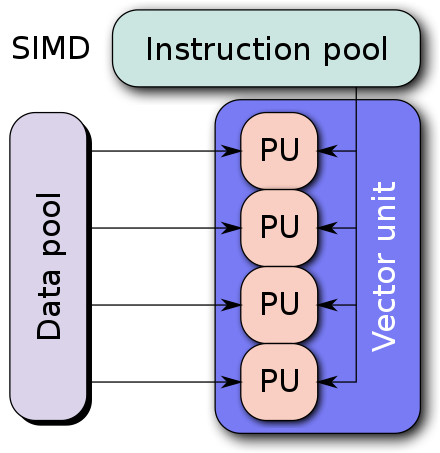

Nowadays, most of Modern CPUs provide direct support for SIMD through hardware design and instruction set architecture (ISA). They can execute single instructions across increasingly large data sets using wider SIMD registers. For instance, a CPU with a 512-bit register can hold 16 32-bit single-precision floating-point numbers, performing operations on them 16 times faster than processing each element individually. When combined with threading and multicore architectures, this leads to significant performance gains.

However, not all algorithms are easily vectorized. For instance, algorithms where computations depend on other elements or loops where each iteration depends on previous iterations are not suitable for vectorization.

In addition, some important conditions must be met for SIMD to be effective. Examples are:

- **Memory Alignment**: Data must be aligned in memory according to vector register sizes.
- **Contiguous Data**: Data should be stored contiguously in memory.
- **Memory Bandwidth**: Adequate memory bandwidth is needed to handle simultaneous data access.


# References

- [Enhancing performance on Pandas Docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html)
- [Sofia Heisler No More Sad Pandas Optimizing Pandas Code for Speed and Efficiency PyCon 2017](https://www.youtube.com/watch?v=HN5d490_KKk)
- [1000x faster data manipulation: vectorizing with Pandas and Numpy](https://www.youtube.com/watch?v=nxWginnBklU)
- [Numba Explained in 30 Minutes - The Python and Numpy Compiler](https://www.youtube.com/watch?v=DPyPmoeUdcE)

- [How vectorization speeds up your Python code](https://pythonspeed.com/articles/vectorization-python/)
- [Pandas vectorization: faster code, slower code, bloated memory](https://pythonspeed.com/articles/pandas-vectorization/)
- [Reducing NumPy memory usage with lossless compression](https://pythonspeed.com/articles/numpy-memory-footprint/)

- [Vectorization: A Key Tool To Improve Performance On Modern CPUs](https://www.intel.com/content/www/us/en/developer/articles/technical/vectorization-a-key-tool-to-improve-performance-on-modern-cpus.html)
